In [1]:
import pandas as pd
import os
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import darts
import math

In [2]:
# from tqdm.keras import TqdmCallback
# import tensorflow_addons as tfa
# from keras_tqdm import TQDMNotebookCallback

In [3]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

In [4]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.utils.statistics import plot_acf
from darts.models.arima import ARIMA
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape

Importing plotly failed. Interactive plots will not work.


In [5]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TF to use only the CPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')  # obtiene las gpus instaladas
if len(gpus) > 0:   # si hay alguna gpu instalada
    # setea para alocar apenas a memória da GPU necessária para as alocações de tempo de execução
    tf.config.experimental.set_memory_growth(gpus[0], True) 
print(gpus)

[]


In [6]:
print(tf.__version__)
print(tf.keras.__version__)
import keras
print(keras.__version__)

2.1.0
2.2.4-tf
2.3.1


Using TensorFlow backend.


In [7]:
import pandas as pd
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential    
from keras.layers import Dense
from keras.layers import Flatten

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

from keras.layers import LSTM

In [8]:
root = r'./'
data_path = r'data/'

# Preparación y Entrenamiento

## Lectura de datos

In [9]:
def print_df(df):
  print(df.shape)
  return df.head()

In [10]:
data_file = data_path+'2017_agg_day_hour.csv'

In [11]:
df = pd.read_csv(root+data_file, parse_dates=True)
df.Fecha = pd.to_datetime(df.Fecha)
df=df.reset_index()
print_df(df)

(3773, 12)


,index,Fecha,Tamb,Tmod,Vdc,Idc,Paparente,Pac,Pdc,Pac*,Pdc*,TONC
0,0,2017-01-01 06:00:00,18.332500,16.995417,383.942917,1.175042,464.887083,455.408333,451.989621,441.821121,438.496964,6.042198
1,1,2017-01-01 07:00:00,22.321250,30.272083,374.950000,2.925125,1095.325417,1091.558750,1093.614275,1121.598759,1123.749676,36.922743
2,2,2017-01-01 08:00:00,24.961250,38.689583,356.565833,4.966667,1757.545000,1755.746667,1768.960983,1871.202144,1885.285511,38.080451
3,3,2017-01-01 09:00:00,25.222917,40.076667,347.599583,6.470000,2224.939583,2223.026250,2248.890346,2384.230654,2411.958771,35.146449
4,4,2017-01-01 10:00:00,24.296250,40.131250,342.759583,7.692000,2598.814167,2596.799583,2636.285487,2786.462959,2828.823842,33.590908


## Codificación de fechas


In [12]:
start = df.iloc[0]['Fecha']

In [13]:
df['Fecha_cod'] = pd.date_range(freq='H', start=start, periods=len(df))
df.head(13)

,index,Fecha,Tamb,Tmod,Vdc,Idc,Paparente,Pac,Pdc,Pac*,Pdc*,TONC,Fecha_cod
0,0,2017-01-01 06:00:00,18.332500,16.995417,383.942917,1.175042,464.887083,455.408333,451.989621,441.821121,438.496964,6.042198,2017-01-01 06:00:00
1,1,2017-01-01 07:00:00,22.321250,30.272083,374.950000,2.925125,1095.325417,1091.558750,1093.614275,1121.598759,1123.749676,36.922743,2017-01-01 07:00:00
2,2,2017-01-01 08:00:00,24.961250,38.689583,356.565833,4.966667,1757.545000,1755.746667,1768.960983,1871.202144,1885.285511,38.080451,2017-01-01 08:00:00
3,3,2017-01-01 09:00:00,25.222917,40.076667,347.599583,6.470000,2224.939583,2223.026250,2248.890346,2384.230654,2411.958771,35.146449,2017-01-01 09:00:00
4,4,2017-01-01 10:00:00,24.296250,40.131250,342.759583,7.692000,2598.814167,2596.799583,2636.285487,2786.462959,2828.823842,33.590908,2017-01-01 10:00:00
5,5,2017-01-01 11:00:00,25.050417,42.937500,337.940000,8.215250,2731.356250,2729.306250,2776.049104,2969.242272,3020.110528,34.371957,2017-01-01 11:00:00
6,6,2017-01-01 12:00:00,25.745417,44.124167,338.329167,8.023958,2660.570417,2658.960000,2711.938675,2911.306451,2969.399377,35.570187,2017-01-01 12:00:00
7,7,2017-01-01 13:00:00,21.740000,25.829167,366.020417,1.521083,567.212083,560.105417,556.150704,564.441982,560.498123,36.753964,2017-01-01 13:00:00
8,8,2017-01-01 14:00:00,20.186667,21.922500,365.706250,0.916750,351.538333,340.181667,335.874500,335.606696,331.358773,32.567566,2017-01-01 14:00:00
9,9,2017-01-01 15:00:00,18.882083,4.700417,83.676667,0.093208,38.940000,34.205417,32.857613,33.431982,32.114377,7.223749,2017-01-01 15:00:00


In [14]:
fechas_origen = df.Fecha

In [15]:
fechas_origen[:11+1]

0    2017-01-01 06:00:00
1    2017-01-01 07:00:00
2    2017-01-01 08:00:00
3    2017-01-01 09:00:00
4    2017-01-01 10:00:00
5    2017-01-01 11:00:00
6    2017-01-01 12:00:00
7    2017-01-01 13:00:00
8    2017-01-01 14:00:00
9    2017-01-01 15:00:00
10   2017-01-01 16:00:00
11   2017-01-02 06:00:00
Name: Fecha, dtype: datetime64[ns]

## Preprocesamiento

In [16]:
series_raw = TimeSeries.from_dataframe(df, 'Fecha_cod', ['Pac','Tamb'])#, freq='H')
type(series_raw)

darts.timeseries.TimeSeries

In [17]:
col_obj = 'Pac'

In [18]:
series_raw[col_obj]

                             Pac
Fecha_cod                       
2017-01-01 06:00:00   455.408333
2017-01-01 07:00:00  1091.558750
2017-01-01 08:00:00  1755.746667
2017-01-01 09:00:00  2223.026250
2017-01-01 10:00:00  2596.799583
...                          ...
2017-06-07 06:00:00  2491.336250
2017-06-07 07:00:00  2270.216667
2017-06-07 08:00:00  1745.285833
2017-06-07 09:00:00  1222.645417
2017-06-07 10:00:00   643.592500

[3773 rows x 1 columns]
Freq: H

In [19]:
series_raw[col_obj][:12]

                             Pac
Fecha_cod                       
2017-01-01 06:00:00   455.408333
2017-01-01 07:00:00  1091.558750
2017-01-01 08:00:00  1755.746667
2017-01-01 09:00:00  2223.026250
2017-01-01 10:00:00  2596.799583
2017-01-01 11:00:00  2729.306250
2017-01-01 12:00:00  2658.960000
2017-01-01 13:00:00   560.105417
2017-01-01 14:00:00   340.181667
2017-01-01 15:00:00    34.205417
2017-01-01 16:00:00   166.082083
2017-01-01 17:00:00   178.710833
Freq: H

In [20]:
len(series_raw)

3773

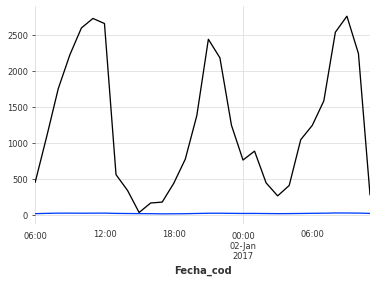

In [21]:
series_raw[0:30].plot()

### Imputación de datos faltantes

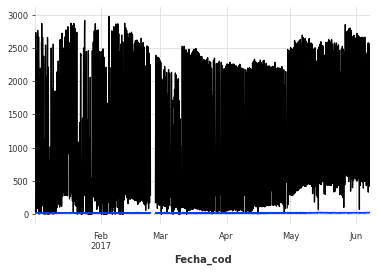

In [22]:
series_raw.plot()

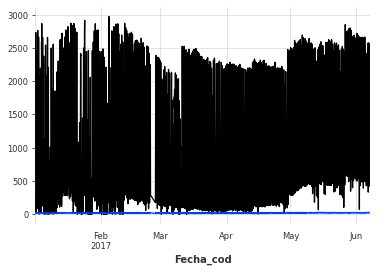

In [23]:
# TODO
filler = MissingValuesFiller()
series = filler.transform(series_raw, method='linear')
series.plot()

### Separación de conjuntos de entrenamiento y validación

In [24]:
train_perc = .8
math.ceil(len(series)*train_perc)

3019

In [25]:
val_len = int(len(series)*(1-train_perc))

In [26]:
val_len -= val_len%11

In [27]:
val_len

748

In [28]:
train, val = series[:-val_len], series[-val_len:]

In [29]:
train

                             Pac       Tamb
Fecha_cod                                  
2017-01-01 06:00:00   455.408333  18.332500
2017-01-01 07:00:00  1091.558750  22.321250
2017-01-01 08:00:00  1755.746667  24.961250
2017-01-01 09:00:00  2223.026250  25.222917
2017-01-01 10:00:00  2596.799583  24.296250
...                          ...        ...
2017-05-07 02:00:00  2582.510417  26.527917
2017-05-07 03:00:00  2287.591250  26.619583
2017-05-07 04:00:00  1820.930000  25.294583
2017-05-07 05:00:00  1200.292917  23.883333
2017-05-07 06:00:00   502.802929  22.205439

[3025 rows x 2 columns]
Freq: H

In [30]:
# plot_acf(train)

## Visualización

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

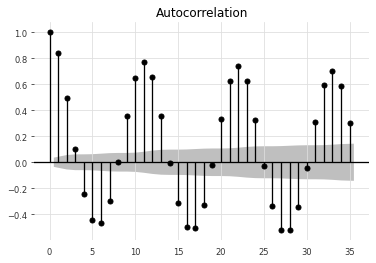

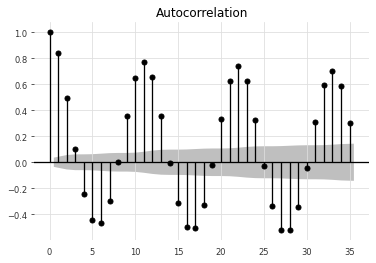

In [32]:
plot_acf(train[col_obj].values())

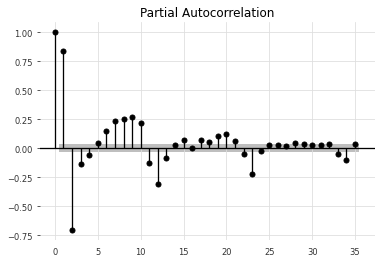

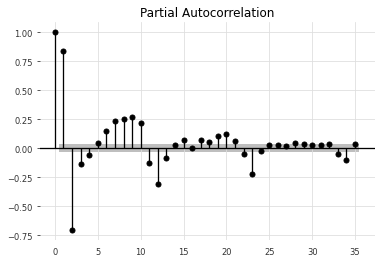

In [33]:
plot_pacf(train[col_obj].values())

## Training (ARIMA)

In [ ]:
model = ARIMA(p=2, d=0, q=11)

In [ ]:
%%time
model.fit(train[col_obj])

In [ ]:
train

In [ ]:
n_predict = 80

In [ ]:
%%time
pred = model.predict(n_predict)
pred

In [ ]:
val[:100]

In [ ]:
train[-200:].plot()
val[col_obj][:n_predict].plot()
pred.plot()

In [ ]:
# %%time
# model.backtest(val,forecast_horizon=11, verbose=True)

In [ ]:
print('MAPE: {:.2f}%'.format(mape(pred, val[col_obj])))

## Training (CNN)

In [34]:
df_columns = ['Pac', 'Tamb']

In [35]:
arr_train = train.values()
arr_train

array([[ 455.40833333,   18.3325    ],
       [1091.55875   ,   22.32125   ],
       [1755.74666667,   24.96125   ],
       ...,
       [1820.93      ,   25.29458333],
       [1200.29291667,   23.88333333],
       [ 502.80292887,   22.20543933]])

In [36]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # calcula el indice del final de la secuencia de entrada y salida actual
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # si el indice de salida es mayor que la longitud de las secuencias entonces deja de generar mas muestras
        if out_end_ix > len(sequences):
            break
            
        # separa la parte de la secuencias de entrada y el vector de traget 
        X.append( sequences[i:end_ix, :] ) # añade las secuencias de entrada a las muestras de  entrenamiento
        y.append( sequences[end_ix:out_end_ix, 0] ) # añade los n_steps_out siguientes como secuencias target de salida de la primera columna 
        
    return np.array(X), np.array(y)   

In [37]:
n_steps_in, n_steps_out = 11, 11
X, y = split_sequences(arr_train, n_steps_in, n_steps_out)
print(X.shape, y.shape)

(3004, 11, 2) (3004, 11)


In [38]:
print(X[0], y[0])

[[ 455.40833333   18.3325    ]
 [1091.55875      22.32125   ]
 [1755.74666667   24.96125   ]
 [2223.02625      25.22291667]
 [2596.79958333   24.29625   ]
 [2729.30625      25.05041667]
 [2658.96         25.74541667]
 [ 560.10541667   21.74      ]
 [ 340.18166667   20.18666667]
 [  34.20541667   18.88208333]
 [ 166.08208333   17.83791667]] [ 178.71083333  439.65916667  774.8675     1381.30458333 2440.075
 2182.44541667 1245.7334728   762.79375     886.52208333  445.84291667
  265.0875    ]


In [40]:
X.shape

(3004, 11, 2)

In [41]:
y.shape

(3004, 11)

In [42]:
%%time
# el numero de features es la tercera dimension del dataset
n_features = X.shape[2]   

# # aplana las secuencias de salida
# n_output = y.shape[1] * y.shape[2]
# y = y.reshape((y.shape[0], n_output))

# define el modelo
modelo_cnn = Sequential()
modelo_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
modelo_cnn.add(MaxPooling1D(pool_size=2))
modelo_cnn.add(Flatten())
modelo_cnn.add(Dense(50, activation='relu'))
modelo_cnn.add(Dense(n_steps_out))
modelo_cnn.compile(optimizer='adam', loss='mse')

# entrena el modelo Vector-Output Mulkti-step MLP con la la data de entrenamiento generada
hist_cnn = modelo_cnn.fit(X, y, epochs=2000, verbose=1)#, callbacks=[TqdmCallback(verbose=2)])




Epoch 1/2000
3004/3004 [==============================] - 0s 111us/step - loss: 690609.4046
Epoch 2/2000
3004/3004 [==============================] - 0s 78us/step - loss: 274249.6638
Epoch 3/2000
3004/3004 [==============================] - 0s 77us/step - loss: 259136.9797
Epoch 4/2000
3004/3004 [==============================] - 0s 77us/step - loss: 250043.4464
Epoch 5/2000
3004/3004 [==============================] - 0s 76us/step - loss: 243378.6300
Epoch 6/2000
3004/3004 [==============================] - 0s 76us/step - loss: 237915.6380
Epoch 7/2000
3004/3004 [==============================] - 0s 75us/step - loss: 233047.8681
Epoch 8/2000
3004/3004 [==============================] - 0s 75us/step - loss: 230557.2877
Epoch 9/2000
3004/3004 [==============================] - 0s 76us/step - loss: 227038.7520
Epoch 10/2000
3004/3004 [==============================] - 0s 76us/step - loss: 222292.6331
Epoch 11/2000
3004/3004 [==============================] - 0s 76us/step - loss: 220004.1

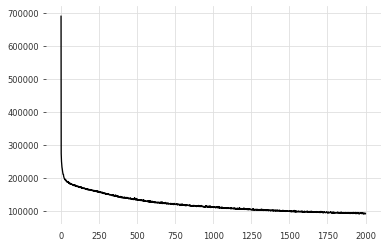

In [43]:
plt.plot(hist_cnn.history['loss'])

In [106]:
# muestra un resumen de la topologia del modelo
modelo_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


In [45]:
# modelo_cnn = modelo

In [46]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_cnn.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 10ms/step


array([[ 472.40182, 1019.47723, 1645.5629 , 2099.2983 , 2353.1594 ,
        2430.9565 , 2312.9104 , 2075.5889 , 1775.2979 , 1239.8512 ,
         633.5824 ]], dtype=float32)

In [109]:
modelo_cnn.save('saved_models/1dcnn_arequipa')

In [110]:
new_model = tf.keras.models.load_model('saved_models/1dcnn_arequipa')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


## Training (LSTM)

In [88]:
# my_model = RNNModel(
#     model='LSTM',
#     dropout=0,
#     batch_size=16,
#     n_epochs=300,
#     optimizer_kwargs={'lr': 1e-3}, 
#     model_name='LSTM_model',
#     log_tensorboard=True,
#     random_state=42,
#     input_chunk_length=11,
#     output_chunk_length=11
# )

In [89]:
# %%time
# my_model.fit(train[col_obj],
#              val_series=val[col_obj],
#              verbose=True)

In [90]:
df_columns = ['Pac', 'Tamb']

In [91]:
arr_train = train.values()
arr_train

array([[ 455.40833333,   18.3325    ],
       [1091.55875   ,   22.32125   ],
       [1755.74666667,   24.96125   ],
       ...,
       [1820.93      ,   25.29458333],
       [1200.29291667,   23.88333333],
       [ 502.80292887,   22.20543933]])

In [92]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # calcula el indice del final de la secuencia de entrada y salida actual
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # si el indice de salida es mayor que la longitud de las secuencias entonces deja de generar mas muestras
        if out_end_ix > len(sequences):
            break
            
        # separa la parte de la secuencias de entrada y el vector de traget 
        X.append( sequences[i:end_ix, :] ) # añade las secuencias de entrada a las muestras de  entrenamiento
        y.append( sequences[end_ix:out_end_ix, 0] ) # añade los n_steps_out siguientes como secuencias target de salida de la primera columna 
        
    return np.array(X), np.array(y)   

In [93]:
n_steps_in, n_steps_out = 11, 11
X, y = split_sequences(arr_train, n_steps_in, n_steps_out)
print(X.shape, y.shape)

(3004, 11, 2) (3004, 11)


In [94]:
print(X[0], y[0])

[[ 455.40833333   18.3325    ]
 [1091.55875      22.32125   ]
 [1755.74666667   24.96125   ]
 [2223.02625      25.22291667]
 [2596.79958333   24.29625   ]
 [2729.30625      25.05041667]
 [2658.96         25.74541667]
 [ 560.10541667   21.74      ]
 [ 340.18166667   20.18666667]
 [  34.20541667   18.88208333]
 [ 166.08208333   17.83791667]] [ 178.71083333  439.65916667  774.8675     1381.30458333 2440.075
 2182.44541667 1245.7334728   762.79375     886.52208333  445.84291667
  265.0875    ]


In [95]:
X.shape

(3004, 11, 2)

In [96]:
y.shape

(3004, 11)

### Modelo LSTM 1

In [97]:
%%time
# el numero de features es la tercera dimension del dataset
n_features = X.shape[2]   

# # aplana las secuencias de salida
# n_output = y.shape[1] * y.shape[2]
# y = y.reshape((y.shape[0], n_output))

# define el modelo
modelo = Sequential()
modelo.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
modelo.add(LSTM(10, activation='relu'))
modelo.add(Dense(n_steps_out))
modelo.compile(optimizer='adam', loss='mse')

# entrena el modelo Stacked LSTM Vector-Output con la la data de entrenamiento generada
hist = modelo.fit(X, y, epochs=738, verbose=1)



Epoch 1/738
3004/3004 [==============================] - 2s 652us/step - loss: 2005376.1455
Epoch 2/738
3004/3004 [==============================] - 1s 490us/step - loss: 1443795.8833
Epoch 3/738
3004/3004 [==============================] - 1s 482us/step - loss: 1239426.9811
Epoch 4/738
3004/3004 [==============================] - 1s 422us/step - loss: 1114007.5647
Epoch 5/738
3004/3004 [==============================] - 1s 424us/step - loss: 898440.4800
Epoch 6/738
3004/3004 [==============================] - 1s 453us/step - loss: 926757.6776
Epoch 7/738
3004/3004 [==============================] - 1s 450us/step - loss: 665893.2582
Epoch 8/738
3004/3004 [==============================] - 1s 449us/step - loss: 611474.1565
Epoch 9/738
3004/3004 [==============================] - 1s 452us/step - loss: 571044.0037
Epoch 10/738
3004/3004 [==============================] - 1s 452us/step - loss: 518487.2867
Epoch 11/738
3004/3004 [==============================] - 1s 453us/step - loss: 48384

In [ ]:
#24m

In [98]:
modelo_lstm = modelo
hist_lstm = hist

In [99]:
# muestra un resumen de la topologia del modelo
modelo_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 11, 50)            10600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 11)                121       
Total params: 13,161
Trainable params: 13,161
Non-trainable params: 0
_________________________________________________________________


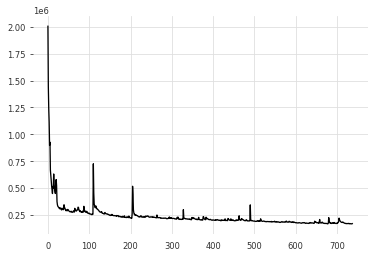

In [100]:
plt.plot(hist_lstm.history['loss'])

In [101]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_lstm.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 63ms/step


array([[ 529.4902,  850.4665, 1372.7491, 1934.6721, 2344.7883, 2484.3901,
        2325.0054, 1916.9274, 1392.348 ,  901.767 ,  585.2945]],
      dtype=float32)

In [104]:
modelo_lstm.save('saved_models/lstm_arequipa')

In [105]:
new_model = tf.keras.models.load_model('saved_models/lstm_arequipa')

# Check its architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 11, 50)            10600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 11)                121       
Total params: 13,161
Trainable params: 13,161
Non-trainable params: 0
_________________________________________________________________


### Modelo LSTM 2

In [73]:
%%time
# el numero de features es la tercera dimension del dataset
n_features = X.shape[2]   

# # aplana las secuencias de salida
# n_output = y.shape[1] * y.shape[2]
# y = y.reshape((y.shape[0], n_output))

# define el modelo
modelo = Sequential()
modelo.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
modelo.add(Dense(50, activation='relu'))
modelo.add(Dense(n_steps_out))
modelo.compile(optimizer='adam', loss='mse')

# entrena el modelo Stacked LSTM Vector-Output con la la data de entrenamiento generada
hist = modelo.fit(X, y, epochs=738, verbose=1)



ValueError: Error when checking target: expected dense_36 to have 3 dimensions, but got array with shape (3004, 11)

In [ ]:
#24m

In [85]:
modelo_lstm = modelo
hist_lstm = hist

In [86]:
# muestra un resumen de la topologia del modelo
modelo_lstm.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 11, 50)            10600     
_________________________________________________________________
lstm_14 (LSTM)               (None, 10)                2440      
_________________________________________________________________
dense_17 (Dense)             (None, 11)                121       
Total params: 13,161
Trainable params: 13,161
Non-trainable params: 0
_________________________________________________________________


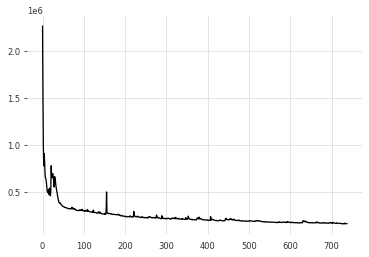

In [87]:
plt.plot(hist_lstm.history['loss'])

In [88]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_lstm.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 72ms/step


array([[ 462.38556,  889.6997 , 1500.8733 , 2040.4104 , 2376.893  ,
        2464.4165 , 2297.677  , 1913.4291 , 1404.0825 ,  824.12726,
         425.62314]], dtype=float32)

## Training (Baseline)

In [577]:
class baseline_model:
    history = None
    def fit(self, history):
        self.history = history
    def predict(self, n, col_obj):
        assert self.history is not None, 'Es necesario realizar entrenamiento (fit)'
        return self.history[-11:-11+n][col_obj] ##No utilizar indices

In [501]:
f = baseline_model()
f.fit(train)
f.predict(2, col_obj)
##No utilizar indices

                             Pac
Fecha_cod                       
2017-05-06 20:00:00   433.067083
2017-05-06 21:00:00  1179.527500
Freq: H

# Comparación de modelos


### Definicion Walkforward

In [576]:
def walk_forward_evaluation(train, val, model, n_pred, col_obj, es_neuronal=False):
    assert len(val)//n_pred >= 2, "Deben haber mínimo 2 días (periodos de pronóstico) de validación"
    history = train
    if es_neuronal:
        pass #model.fit(train)
    arr_pred=None
    arr_real=None 
    for t in range(len(val)-n_pred):
        print(f't={t}/{len(val)-n_pred-1}')
        print(f'history len = {len(history)}')
        print()
        
        #valores predichos
        if not es_neuronal:
            model.fit(history[col_obj])
            pred = model.predict(n_pred)
        if not isinstance(pred, np.ndarray):
            pred = pred.univariate_values().reshape((1,-1))
        else:
            pred = pred.reshape((1,-1))
        if arr_pred is None:
            arr_pred = pred
        else:
            arr_pred = np.concatenate([arr_pred,pred], axis=0)
            
        #valores reales:
        real = val[t:t+n_pred][col_obj].univariate_values().reshape((1,-1))
        if arr_real is None:
            arr_real = real
        else:
            arr_real = np.concatenate([arr_real,real], axis=0)
        #history_new = history.append(val[t])
        #history = history_new
        history = history.append(val[t])
    
    return arr_pred, arr_real
    

#### Walk forward para modelos neuronales

In [111]:
def walk_forward_evaluation_neuronal(train, val, model, n_pred, col_obj, es_neuronal=True):
    assert len(val)//n_pred >= 2, "Deben haber mínimo 2 días (periodos de pronóstico) de validación"
    x_input = train[-11:]
    if es_neuronal:
        pass #model.fit(train)
    
    arr_pred=None
    arr_real=None 
    for t in range(val.shape[0]-n_pred):
        if (t%100 == 0) or (t == (val.shape[0]-n_pred-1)):
            print(f't={t}/{val.shape[0]-n_pred-1}')
            print(f'history len = {x_input.shape[0]}')
            print()
        
        #valores predichos
        if not es_neuronal:
#             model.fit(history[col_obj])
            pred = model.predict(n_pred)
        else:
            pred = model.predict(x_input.reshape((1, 11, train.shape[1])) )
            
        if not isinstance(pred, np.ndarray):
            pred = pred.univariate_values().reshape((1,-1))
        else:
            pred = pred.reshape((1,-1))
            
        if arr_pred is None:
            arr_pred = pred
        else:
            arr_pred = np.concatenate([arr_pred,pred], axis=0)
            
        #valores reales:
        if not es_neuronal:
            real = val[t:t+n_pred][col_obj].univariate_values().reshape((1,-1))
        else:
            real = val[t:t+n_pred,0].reshape((1,-1))
        if arr_real is None:
            arr_real = real
        else:
            arr_real = np.concatenate([arr_real,real], axis=0)
        #history_new = history.append(val[t])
        #history = history_new
        x_input = np.vstack((x_input[1:],val[t]))
    
    return arr_pred, arr_real
    

### Prediction ARIMA

In [ ]:
model = ARIMA(p=2, d=0, q=11)
n_pred = 11
val_wfe = val[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train
print(len(train_wfe))
print(len(val_wfe))

In [436]:
%%time
model.fit(train[col_obj])

CPU times: user 10min 28s, sys: 11min 41s, total: 22min 9s
Wall time: 55.6 s


In [437]:
n_predict = 80

In [438]:
%%time
pred = model.predict(n_predict)
pred

CPU times: user 478 ms, sys: 523 ms, total: 1 s
Wall time: 41.8 ms


                               0
2017-05-07 07:00:00   347.063028
2017-05-07 08:00:00   641.926299
2017-05-07 09:00:00  1174.898180
2017-05-07 10:00:00  1743.496876
2017-05-07 11:00:00  2156.955701
...                          ...
2017-05-10 10:00:00   722.461815
2017-05-10 11:00:00   389.781913
2017-05-10 12:00:00   336.146406
2017-05-10 13:00:00   577.850294
2017-05-10 14:00:00  1037.568886

[80 rows x 1 columns]
Freq: H

In [439]:
val[:100]

                             Pac       Tamb
Fecha_cod                                  
2017-05-07 07:00:00   434.088750  14.522917
2017-05-07 08:00:00  1170.127083  19.560417
2017-05-07 09:00:00  1785.090417  24.650000
2017-05-07 10:00:00  2249.656667  24.322500
2017-05-07 11:00:00  2549.714167  24.848750
...                          ...        ...
2017-05-11 06:00:00  2071.770833  24.311667
2017-05-11 07:00:00  1410.895000  23.180833
2017-05-11 08:00:00  1132.319583  23.412083
2017-05-11 09:00:00   536.687917  21.356250
2017-05-11 10:00:00   309.435833  17.710417

[100 rows x 2 columns]
Freq: H

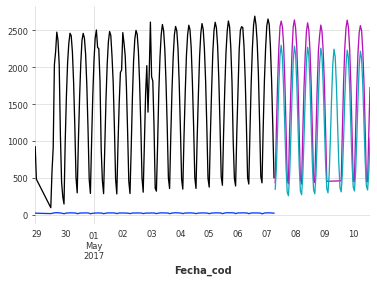

In [440]:
train[-200:].plot()
val[col_obj][:n_predict].plot()
pred.plot()

In [329]:
# %%time
# model.backtest(val,forecast_horizon=11, verbose=True)

In [441]:
print('MAPE: {:.2f}%'.format(mape(pred, val[col_obj])))

MAPE: 46.25%


In [319]:
# print('MAPE: {:.2f}%'.format(mape(pred, val[col_obj])))

MAPE: 33.43%


#### Walk forward ARIMA

In [460]:
model = ARIMA(p=2, d=0, q=11)
n_pred = 11
val_wfe = val[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train
print(len(train_wfe))
print(len(val_wfe))

3025
33


In [461]:
%%time
arr_pred, arr_real = walk_forward_evaluation(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=False)

t=0/21
history len = 3025

t=1/21
history len = 3026

t=2/21
history len = 3027

t=3/21
history len = 3028

t=4/21
history len = 3029

t=5/21
history len = 3030

t=6/21
history len = 3031

t=7/21
history len = 3032

t=8/21
history len = 3033

t=9/21
history len = 3034

t=10/21
history len = 3035

t=11/21
history len = 3036

t=12/21
history len = 3037

t=13/21
history len = 3038

t=14/21
history len = 3039

t=15/21
history len = 3040

t=16/21
history len = 3041

t=17/21
history len = 3042

t=18/21
history len = 3043

t=19/21
history len = 3044

t=20/21
history len = 3045

t=21/21
history len = 3046

CPU times: user 5h 5min 9s, sys: 6h 20min 43s, total: 11h 25min 52s
Wall time: 36min 57s


In [462]:
arr_pred.shape

(22, 11)

In [463]:
arr_real.shape

(22, 11)

#### Metric Evaluation ARIMA

In [464]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [465]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([160.64776544, 270.69151432, 315.9885493 , 334.01812193,
       348.00484558, 372.36320726, 403.76765114, 427.86701613,
       436.60018178, 432.48102117, 439.43991836])

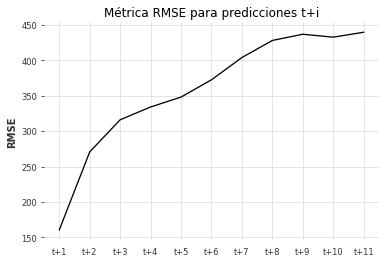

In [466]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [467]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.95698311, 0.8716135 , 0.8166354 , 0.78997067, 0.77035765,
       0.73757084, 0.69279894, 0.65660533, 0.64425295, 0.65094365,
       0.63929683])

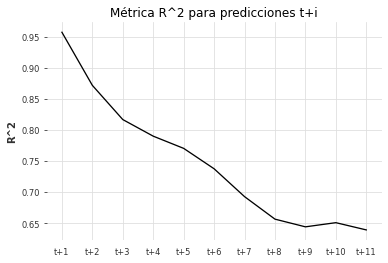

In [468]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

###  Predicción Baseline

In [202]:
n_pred = 11
val_wfe = val[:n_pred*4] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train
print(len(train_wfe))
print(len(val_wfe))

3025
44


In [203]:
class baseline_model:
    history = None
    n_pred = 11
    def fit(self, history):
        self.history = history
    def predict(self, n):
        assert self.history is not None, 'Es necesario realizar entrenamiento (fit)'
        assert n<=self.n_pred, f'n debe ser menor a self.n_pred ({self.n_pred})'
        if n>=self.n_pred:
            return self.history[-self.n_pred:]
        return self.history[-self.n_pred:-self.n_pred+n] ##No utilizar indices

In [204]:
f = baseline_model()
f.fit(train_wfe)
f.predict(11)
##No utilizar indices

                             Pac       Tamb
Fecha_cod                                  
2017-05-06 20:00:00   433.067083  13.104167
2017-05-06 21:00:00  1179.527500  18.623333
2017-05-06 22:00:00  1814.646667  24.077083
2017-05-06 23:00:00  2256.192917  25.899583
2017-05-07 00:00:00  2561.787083  26.175417
2017-05-07 01:00:00  2653.807083  26.612917
2017-05-07 02:00:00  2582.510417  26.527917
2017-05-07 03:00:00  2287.591250  26.619583
2017-05-07 04:00:00  1820.930000  25.294583
2017-05-07 05:00:00  1200.292917  23.883333
2017-05-07 06:00:00   502.802929  22.205439
Freq: H

### Walk Forward Baseline

In [205]:
model = baseline_model()
n_pred = 11
val_wfe = val[:n_pred*2] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train
print(len(train_wfe))
print(len(val_wfe))

3025
22


In [206]:
%%time
arr_pred, arr_real = walk_forward_evaluation(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=False)

NameError: name 'walk_forward_evaluation' is not defined

In [207]:
arr_pred

array([[ 472.40182, 1019.47723, 1645.5629 , 2099.2983 , 2353.1594 ,
        2430.9565 , 2312.9104 , 2075.5889 , 1775.2979 , 1239.8512 ,
         633.5824 ],
       [ 992.13354, 1608.4357 , 2145.872  , 2423.701  , 2570.614  ,
        2554.2212 , 2281.9475 , 1940.9187 , 1354.8011 ,  633.49774,
         563.6809 ],
       [1836.7463 , 2311.036  , 2677.721  , 2721.9658 , 2499.691  ,
        2283.1628 , 1895.6794 , 1421.3423 ,  934.6142 ,  716.7769 ,
        1255.8165 ],
       [2241.287  , 2547.7168 , 2696.4998 , 2559.491  , 2225.5786 ,
        1837.4777 , 1234.8635 ,  606.9672 ,  558.9049 , 1085.0864 ,
        1722.1653 ],
       [2498.823  , 2559.8347 , 2462.436  , 2060.6218 , 1584.6791 ,
        1096.2251 ,  561.5354 ,  466.13483, 1184.402  , 1940.8229 ,
        2296.9702 ],
       [2637.7786 , 2471.894  , 2202.5186 , 1781.2722 , 1084.9849 ,
         487.80957,  503.1107 , 1185.7072 , 1922.7065 , 2383.294  ,
        2596.6628 ],
       [2379.94   , 2020.218  , 1621.5594 , 1120.4845 ,  5

In [196]:
arr_real

array([[ 434.08875   , 1170.12708333, 1785.09041667, 2249.65666667,
        2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333],
       [1170.12708333, 1785.09041667, 2249.65666667, 2549.71416667,
        2626.0275    , 2549.17375   , 2307.63208333, 1830.59958333,
        1196.37333333,  483.49708333,  419.27583333],
       [1785.09041667, 2249.65666667, 2549.71416667, 2626.0275    ,
        2549.17375   , 2307.63208333, 1830.59958333, 1196.37333333,
         483.49708333,  419.27583333, 1134.27166667],
       [2249.65666667, 2549.71416667, 2626.0275    , 2549.17375   ,
        2307.63208333, 1830.59958333, 1196.37333333,  483.49708333,
         419.27583333, 1134.27166667, 1675.97208333],
       [2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333,  419.27583333,
        1134.27166667, 1675.97208333, 2210.39333333],
       [2626.0275    , 2549.17375   , 2307.6320833

#### Metric Evaluation Baseline

In [197]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [198]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([115.10191634, 132.69982343, 120.77863339, 107.65245094,
       118.96826602, 131.887571  , 143.15994299, 177.28378744,
       216.6817493 , 179.65628844, 139.2870071 ])

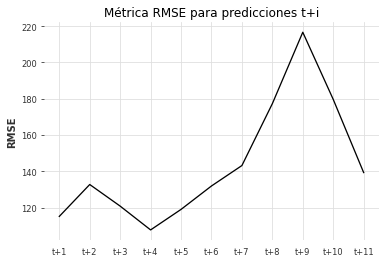

In [199]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [200]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.97433916, 0.96622956, 0.97345903, 0.97950419, 0.97658481,
       0.97279544, 0.96186727, 0.93689973, 0.88881311, 0.93188785,
       0.96104979])

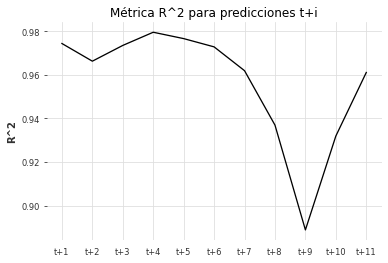

In [201]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

### Prediction CNN


In [51]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_cnn.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 1ms/step


array([[ 472.40182, 1019.47723, 1645.5629 , 2099.2983 , 2353.1594 ,
        2430.9565 , 2312.9104 , 2075.5889 , 1775.2979 , 1239.8512 ,
         633.5824 ]], dtype=float32)

In [52]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_cnn.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 1ms/step


array([[ 472.40182, 1019.47723, 1645.5629 , 2099.2983 , 2353.1594 ,
        2430.9565 , 2312.9104 , 2075.5889 , 1775.2979 , 1239.8512 ,
         633.5824 ]], dtype=float32)

### Walk Forward CNN 2

In [208]:
model = modelo_cnn
n_pred = 11
val_wfe = val.values()[:n_pred*3] # Minimo 2 dias
train_wfe = train[-n_pred*40:]
train_wfe = train.values()
print(len(train_wfe))
print(len(val_wfe))

3025
33


In [209]:
n_features

2

In [210]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/21
history len = 11

t=21/21
history len = 11

CPU times: user 19.1 ms, sys: 4.71 ms, total: 23.9 ms
Wall time: 18.7 ms


In [211]:
arr_pred

array([[ 472.40182, 1019.47723, 1645.5629 , 2099.2983 , 2353.1594 ,
        2430.9565 , 2312.9104 , 2075.5889 , 1775.2979 , 1239.8512 ,
         633.5824 ],
       [ 992.13354, 1608.4357 , 2145.872  , 2423.701  , 2570.614  ,
        2554.2212 , 2281.9475 , 1940.9187 , 1354.8011 ,  633.49774,
         563.6809 ],
       [1836.7463 , 2311.036  , 2677.721  , 2721.9658 , 2499.691  ,
        2283.1628 , 1895.6794 , 1421.3423 ,  934.6142 ,  716.7769 ,
        1255.8165 ],
       [2241.287  , 2547.7168 , 2696.4998 , 2559.491  , 2225.5786 ,
        1837.4777 , 1234.8635 ,  606.9672 ,  558.9049 , 1085.0864 ,
        1722.1653 ],
       [2498.823  , 2559.8347 , 2462.436  , 2060.6218 , 1584.6791 ,
        1096.2251 ,  561.5354 ,  466.13483, 1184.402  , 1940.8229 ,
        2296.9702 ],
       [2637.7786 , 2471.894  , 2202.5186 , 1781.2722 , 1084.9849 ,
         487.80957,  503.1107 , 1185.7072 , 1922.7065 , 2383.294  ,
        2596.6628 ],
       [2379.94   , 2020.218  , 1621.5594 , 1120.4845 ,  5

In [212]:
arr_real

array([[ 434.08875   , 1170.12708333, 1785.09041667, 2249.65666667,
        2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333],
       [1170.12708333, 1785.09041667, 2249.65666667, 2549.71416667,
        2626.0275    , 2549.17375   , 2307.63208333, 1830.59958333,
        1196.37333333,  483.49708333,  419.27583333],
       [1785.09041667, 2249.65666667, 2549.71416667, 2626.0275    ,
        2549.17375   , 2307.63208333, 1830.59958333, 1196.37333333,
         483.49708333,  419.27583333, 1134.27166667],
       [2249.65666667, 2549.71416667, 2626.0275    , 2549.17375   ,
        2307.63208333, 1830.59958333, 1196.37333333,  483.49708333,
         419.27583333, 1134.27166667, 1675.97208333],
       [2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333,  419.27583333,
        1134.27166667, 1675.97208333, 2210.39333333],
       [2626.0275    , 2549.17375   , 2307.6320833

#### Metric Evaluation CNN

In [213]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [214]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([115.10191634, 132.69982343, 120.77863339, 107.65245094,
       118.96826602, 131.887571  , 143.15994299, 177.28378744,
       216.6817493 , 179.65628844, 139.2870071 ])

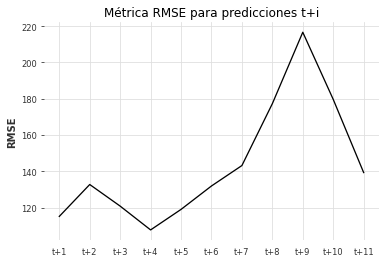

In [215]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [216]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.97433916, 0.96622956, 0.97345903, 0.97950419, 0.97658481,
       0.97279544, 0.96186727, 0.93689973, 0.88881311, 0.93188785,
       0.96104979])

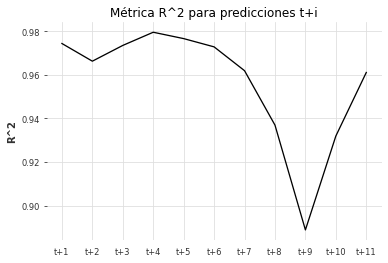

In [217]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

### Walk Forward CNN

In [176]:
model = modelo_cnn
n_pred = 11
val_wfe = val.values()[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train.values()
print(len(train_wfe))
print(len(val_wfe))

3025
33


In [177]:
n_features

2

In [178]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/21
history len = 11

t=1/21
history len = 11

t=2/21
history len = 11

t=3/21
history len = 11

t=4/21
history len = 11

t=5/21
history len = 11

t=6/21
history len = 11

t=7/21
history len = 11

t=8/21
history len = 11

t=9/21
history len = 11

t=10/21
history len = 11

t=11/21
history len = 11

t=12/21
history len = 11

t=13/21
history len = 11

t=14/21
history len = 11

t=15/21
history len = 11

t=16/21
history len = 11

t=17/21
history len = 11

t=18/21
history len = 11

t=19/21
history len = 11

t=20/21
history len = 11

t=21/21
history len = 11

CPU times: user 51.6 ms, sys: 6.66 ms, total: 58.3 ms
Wall time: 33.1 ms


In [179]:
arr_pred

array([[ 414.4701 ,  991.9556 , 1628.1176 , 2084.6936 , 2385.5737 ,
        2474.6086 , 2354.728  , 2069.403  , 1706.6467 , 1136.0331 ,
         471.2032 ],
       [1059.8314 , 1695.9735 , 2176.3994 , 2486.659  , 2617.3767 ,
        2538.938  , 2260.71   , 1826.1381 , 1196.556  ,  559.9637 ,
         420.77014],
       [1713.2297 , 2088.0686 , 2319.5803 , 2379.7202 , 2341.3887 ,
        2157.75   , 1788.2705 , 1331.0879 ,  756.7093 ,  634.5925 ,
        1255.1155 ],
       [2245.996  , 2434.8813 , 2500.2214 , 2381.8313 , 2127.1792 ,
        1761.2798 , 1132.0209 ,  546.4005 ,  504.9545 , 1090.4867 ,
        1727.251  ],
       [2585.7183 , 2526.8582 , 2369.3125 , 2161.7126 , 1882.8794 ,
        1348.5715 ,  683.1343 ,  579.24207, 1233.6035 , 1963.0629 ,
        2331.5867 ],
       [2614.0374 , 2494.0652 , 2190.7373 , 1748.7565 , 1179.9563 ,
         617.4442 ,  563.5681 , 1198.7642 , 1927.3892 , 2528.515  ,
        2747.6448 ],
       [2514.6096 , 2185.3284 , 1722.7565 , 1192.4146 ,  6

In [180]:
arr_real

array([[ 434.08875   , 1170.12708333, 1785.09041667, 2249.65666667,
        2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333],
       [1170.12708333, 1785.09041667, 2249.65666667, 2549.71416667,
        2626.0275    , 2549.17375   , 2307.63208333, 1830.59958333,
        1196.37333333,  483.49708333,  419.27583333],
       [1785.09041667, 2249.65666667, 2549.71416667, 2626.0275    ,
        2549.17375   , 2307.63208333, 1830.59958333, 1196.37333333,
         483.49708333,  419.27583333, 1134.27166667],
       [2249.65666667, 2549.71416667, 2626.0275    , 2549.17375   ,
        2307.63208333, 1830.59958333, 1196.37333333,  483.49708333,
         419.27583333, 1134.27166667, 1675.97208333],
       [2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333,  419.27583333,
        1134.27166667, 1675.97208333, 2210.39333333],
       [2626.0275    , 2549.17375   , 2307.6320833

#### Metric Evaluation CNN

In [181]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [182]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([ 66.03059827, 124.09463853, 152.07329848, 140.44600895,
       128.4332031 , 137.22035643, 117.07118223, 129.04759466,
       147.78023468, 166.15645215, 130.88758569])

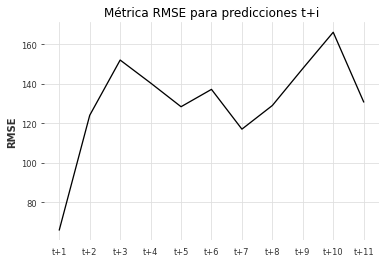

In [183]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [184]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.99245755, 0.97053042, 0.95181674, 0.95881791, 0.96936259,
       0.96646702, 0.9756328 , 0.97043425, 0.96130104, 0.9557406 ,
       0.97213966])

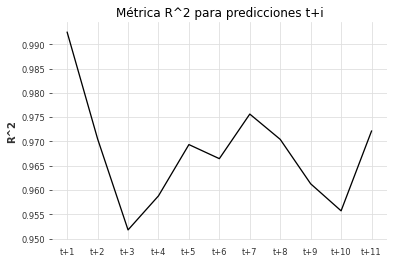

In [185]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

### Prediction LSTM


In [113]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_lstm.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 4ms/step


array([[ 529.4902,  850.4665, 1372.7491, 1934.6721, 2344.7883, 2484.3901,
        2325.0054, 1916.9274, 1392.348 ,  901.767 ,  585.2945]],
      dtype=float32)

### Walk Forward LSTM 2

In [147]:
model = modelo_lstm
n_pred = 11
val_wfe = val.values() # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train.values()
print(len(train_wfe))
print(len(val_wfe))

3025
748


In [148]:
n_features

2

In [149]:
val_wfe.shape

(748, 2)

In [150]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/736
history len = 11

t=100/736
history len = 11

t=200/736
history len = 11

t=300/736
history len = 11

t=400/736
history len = 11

t=500/736
history len = 11

t=600/736
history len = 11

t=700/736
history len = 11

t=736/736
history len = 11

CPU times: user 5.7 s, sys: 1.23 s, total: 6.93 s
Wall time: 2.44 s


In [151]:
arr_pred

array([[ 529.4902 ,  850.4665 , 1372.7491 , ..., 1392.348  ,  901.767  ,
         585.2945 ],
       [ 820.2265 , 1179.9504 , 1634.42   , ..., 1149.3137 ,  822.6982 ,
         691.2423 ],
       [1596.8406 , 2108.9172 , 2470.2366 , ...,  678.0727 ,  687.595  ,
         982.55493],
       ...,
       [1577.1418 , 1088.3132 ,  705.5219 , ..., 2493.093  , 2251.5505 ,
        1845.7052 ],
       [ 944.72644,  739.24176,  775.0812 , ..., 2296.8447 , 1849.3826 ,
        1330.1646 ],
       [ 424.88797,  496.20908,  932.7001 , ..., 2057.3496 , 1562.4802 ,
        1016.77936]], dtype=float32)

In [152]:
arr_real

array([[ 434.08875   , 1170.12708333, 1785.09041667, ..., 1830.59958333,
        1196.37333333,  483.49708333],
       [1170.12708333, 1785.09041667, 2249.65666667, ..., 1196.37333333,
         483.49708333,  419.27583333],
       [1785.09041667, 2249.65666667, 2549.71416667, ...,  483.49708333,
         419.27583333, 1134.27166667],
       ...,
       [1807.55041667, 1250.87416667,  421.00041667, ..., 2542.35708333,
        2491.33625   , 2270.21666667],
       [1250.87416667,  421.00041667,  425.24208333, ..., 2491.33625   ,
        2270.21666667, 1745.28583333],
       [ 421.00041667,  425.24208333, 1057.35625   , ..., 2270.21666667,
        1745.28583333, 1222.64541667]])

#### Metric Evaluation LSTM

In [153]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [154]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([270.13005066, 346.40415839, 370.7654308 , 360.06783521,
       394.4673246 , 411.83938407, 380.71839117, 364.21451049,
       373.51569176, 374.55337544, 367.34443071])

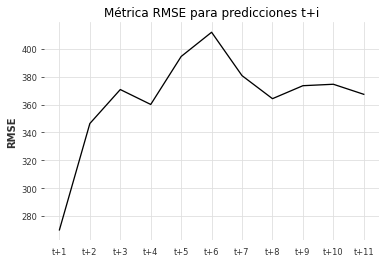

In [155]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [156]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.86788888, 0.74556947, 0.65040619, 0.62393271, 0.53358361,
       0.5781889 , 0.70589322, 0.7192441 , 0.64662368, 0.65336951,
       0.72082994])

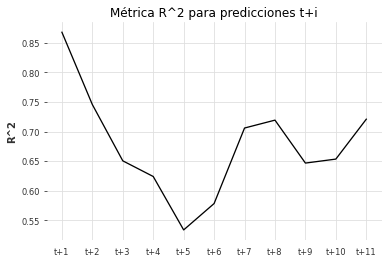

In [157]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

### Walk Forward LSTM

In [187]:
model = modelo_lstm
n_pred = 11
val_wfe = val.values()[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train.values()
print(len(train_wfe))
print(len(val_wfe))

3025
33


In [188]:
n_features

2

In [189]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/21
history len = 11

t=1/21
history len = 11

t=2/21
history len = 11

t=3/21
history len = 11

t=4/21
history len = 11

t=5/21
history len = 11

t=6/21
history len = 11

t=7/21
history len = 11

t=8/21
history len = 11

t=9/21
history len = 11

t=10/21
history len = 11

t=11/21
history len = 11

t=12/21
history len = 11

t=13/21
history len = 11

t=14/21
history len = 11

t=15/21
history len = 11

t=16/21
history len = 11

t=17/21
history len = 11

t=18/21
history len = 11

t=19/21
history len = 11

t=20/21
history len = 11

t=21/21
history len = 11

CPU times: user 238 ms, sys: 67.2 ms, total: 305 ms
Wall time: 102 ms


In [190]:
arr_pred

array([[ 462.38556,  889.6997 , 1500.8733 , 2040.4104 , 2376.893  ,
        2464.4165 , 2297.677  , 1913.4291 , 1404.0825 ,  824.12726,
         425.62314],
       [ 737.5334 , 1241.9738 , 1720.9745 , 2091.577  , 2285.7573 ,
        2280.4714 , 2039.9794 , 1579.5532 ,  986.767  ,  465.55008,
         379.3336 ],
       [1708.7362 , 2033.2561 , 2169.305  , 2285.4094 , 2399.606  ,
        2276.7283 , 1734.406  ,  988.9572 ,  515.4057 ,  562.57416,
        1035.902  ],
       [2146.0974 , 2341.3909 , 2341.6892 , 2238.6692 , 2063.3533 ,
        1654.9498 , 1020.3772 ,  512.823  ,  541.0208 , 1062.4093 ,
        1715.3575 ],
       [2357.3774 , 2431.8064 , 2301.9375 , 1942.7925 , 1433.8888 ,
         880.18823,  506.30902,  562.7502 , 1056.2153 , 1673.8301 ,
        2184.635  ],
       [2513.2107 , 2453.1042 , 2152.5264 , 1581.799  ,  896.07104,
         406.41943,  395.2406 ,  908.8264 , 1604.0752 , 2086.71   ,
        2391.2146 ],
       [2407.9592 , 2057.7625 , 1500.4854 ,  858.83453,  3

In [191]:
arr_real

array([[ 434.08875   , 1170.12708333, 1785.09041667, 2249.65666667,
        2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333],
       [1170.12708333, 1785.09041667, 2249.65666667, 2549.71416667,
        2626.0275    , 2549.17375   , 2307.63208333, 1830.59958333,
        1196.37333333,  483.49708333,  419.27583333],
       [1785.09041667, 2249.65666667, 2549.71416667, 2626.0275    ,
        2549.17375   , 2307.63208333, 1830.59958333, 1196.37333333,
         483.49708333,  419.27583333, 1134.27166667],
       [2249.65666667, 2549.71416667, 2626.0275    , 2549.17375   ,
        2307.63208333, 1830.59958333, 1196.37333333,  483.49708333,
         419.27583333, 1134.27166667, 1675.97208333],
       [2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333,  419.27583333,
        1134.27166667, 1675.97208333, 2210.39333333],
       [2626.0275    , 2549.17375   , 2307.6320833

#### Metric Evaluation LSTM

In [192]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [193]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([197.55610394, 238.56362632, 305.55899102, 324.96683809,
       274.55980543, 231.67606308, 221.54597819, 211.42255549,
       184.07502815, 164.89740173, 124.90828435])

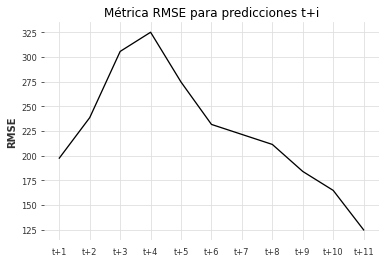

In [194]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [195]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.9354495 , 0.8969718 , 0.8117387 , 0.78788145, 0.86891083,
       0.9153973 , 0.91270125, 0.90583947, 0.93250621, 0.94930829,
       0.97196451])

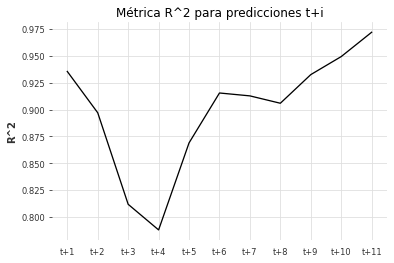

In [196]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

In [197]:
modelo_cnn.predict(x_input, verbose=1)

1/1 [==============================] - 0s 1ms/step


array([[ 414.4701,  991.9556, 1628.1176, 2084.6936, 2385.5737, 2474.6086,
        2354.728 , 2069.403 , 1706.6467, 1136.0331,  471.2032]],
      dtype=float32)

In [198]:
modelo_lstm.predict(x_input, verbose=1)

1/1 [==============================] - 0s 5ms/step


array([[ 462.38556,  889.6997 , 1500.8733 , 2040.4104 , 2376.893  ,
        2464.4165 , 2297.677  , 1913.4291 , 1404.0825 ,  824.12726,
         425.62314]], dtype=float32)

### Comapración de Análisis Walk Forward

In [219]:
rmse_arima = np.array([160.64776544, 270.69151432, 315.9885493 , 334.01812193,
       348.00484558, 372.36320726, 403.76765114, 427.86701613,
       436.60018178, 432.48102117, 439.43991836])
rmse_baseline = np.array([37.95487422, 37.95728727, 38.30072428, 39.2570819 , 40.79120364,
       43.14413184, 43.56537003, 43.23455526, 44.20596312, 44.68720473,
       44.91275993])
rmse_cnn = np.array([ 66.03059827, 124.09463853, 152.07329848, 140.44600895,
       128.4332031 , 137.22035643, 117.07118223, 129.04759466,
       147.78023468, 166.15645215, 130.88758569])
rmse_lstm = np.array([197.55610394, 238.56362632, 305.55899102, 324.96683809,
       274.55980543, 231.67606308, 221.54597819, 211.42255549,
       184.07502815, 164.89740173, 124.90828435])
ls_rmse = [  rmse_arima,rmse_cnn,rmse_lstm,rmse_baseline]

In [220]:
r2_arima = np.array([0.95698311, 0.8716135 , 0.8166354 , 0.78997067, 0.77035765,
       0.73757084, 0.69279894, 0.65660533, 0.64425295, 0.65094365,
       0.63929683])
r2_baseline = np.array([0.99760507, 0.99761134, 0.99757768, 0.99745508, 0.99724291,
       0.99690913, 0.99684312, 0.99687132, 0.99672303, 0.9966502 ,
       0.99664528])
r2_cnn = np.array([0.99245755, 0.97053042, 0.95181674, 0.95881791, 0.96936259,
       0.96646702, 0.9756328 , 0.97043425, 0.96130104, 0.9557406 ,
       0.97213966])
r2_lstm = np.array([0.9354495 , 0.8969718 , 0.8117387 , 0.78788145, 0.86891083,
       0.9153973 , 0.91270125, 0.90583947, 0.93250621, 0.94930829,
       0.97196451])
ls_r2 = [ r2_arima, r2_cnn,r2_lstm,r2_baseline]

In [221]:
nombres_modelos = [ 'ARIMA', 'CNN', 'LSTM','Baseline']

#### Comparación de métrica RMSE 

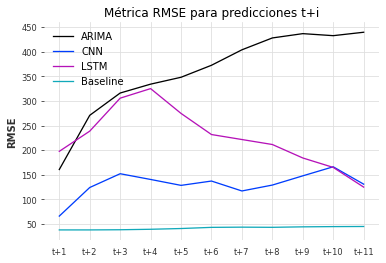

In [222]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
for ls_metric_t in ls_rmse:
    plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.legend(nombres_modelos)
plt.show()

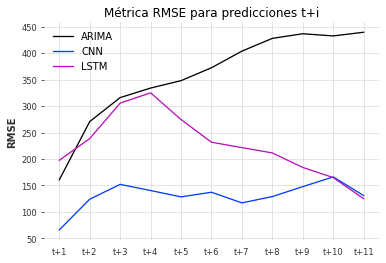

In [223]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
for ls_metric_t in ls_rmse[:-1]:
    plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.legend(nombres_modelos[:-1])
plt.show()

#### Comparación de métrica R^2

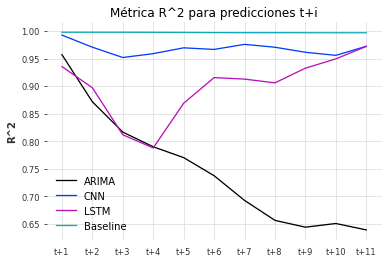

In [226]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
for ls_metric_t in ls_r2:
    plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.legend(nombres_modelos)
plt.show()

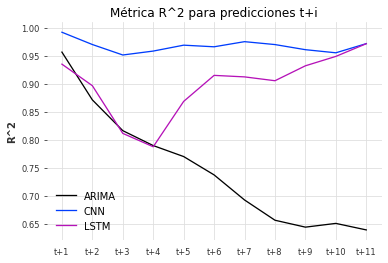

In [227]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
for ls_metric_t in ls_r2[:-1]:
    plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.legend(nombres_modelos[:-1])
plt.show()

# Gráficos de pronóstico

In [218]:
series

                             Pac       Tamb
Fecha_cod                                  
2017-01-01 06:00:00   455.408333  18.332500
2017-01-01 07:00:00  1091.558750  22.321250
2017-01-01 08:00:00  1755.746667  24.961250
2017-01-01 09:00:00  2223.026250  25.222917
2017-01-01 10:00:00  2596.799583  24.296250
...                          ...        ...
2017-06-07 06:00:00  2491.336250  28.547500
2017-06-07 07:00:00  2270.216667  28.000833
2017-06-07 08:00:00  1745.285833  27.032917
2017-06-07 09:00:00  1222.645417  25.306667
2017-06-07 10:00:00   643.592500  24.572500

[3773 rows x 2 columns]
Freq: H

In [247]:
df_new_diag = pd.DataFrame(series.values(), columns=['Pac', 'Tamb'])
df_new_diag

,Pac,Tamb
0,455.408333,18.332500
1,1091.558750,22.321250
2,1755.746667,24.961250
3,2223.026250,25.222917
4,2596.799583,24.296250
...,...,...
3768,2491.336250,28.547500
3769,2270.216667,28.000833
3770,1745.285833,27.032917
3771,1222.645417,25.306667


,0,1
3025,434.088750,14.522917
3026,1170.127083,19.560417
3027,1785.090417,24.650000
3028,2249.656667,24.322500
3029,2549.714167,24.848750
...,...,...
3768,2491.336250,28.547500
3769,2270.216667,28.000833
3770,1745.285833,27.032917
3771,1222.645417,25.306667


In [219]:
len(train)

3025

In [220]:
len(val)

748

In [238]:

df_diag = df.copy()
df_diag['Fecha_2020']= df_diag.Fecha.apply(lambda x: x+datetime.timedelta(weeks=53*3))
df_diag

,index,Fecha,Tamb,Tmod,Vdc,Idc,Paparente,Pac,Pdc,Pac*,Pdc*,TONC,Fecha_cod,Fecha_2020
0,0,2017-01-01 06:00:00,18.332500,16.995417,383.942917,1.175042,464.887083,455.408333,451.989621,441.821121,438.496964,6.042198,2017-01-01 06:00:00,2020-01-19 06:00:00
1,1,2017-01-01 07:00:00,22.321250,30.272083,374.950000,2.925125,1095.325417,1091.558750,1093.614275,1121.598759,1123.749676,36.922743,2017-01-01 07:00:00,2020-01-19 07:00:00
2,2,2017-01-01 08:00:00,24.961250,38.689583,356.565833,4.966667,1757.545000,1755.746667,1768.960983,1871.202144,1885.285511,38.080451,2017-01-01 08:00:00,2020-01-19 08:00:00
3,3,2017-01-01 09:00:00,25.222917,40.076667,347.599583,6.470000,2224.939583,2223.026250,2248.890346,2384.230654,2411.958771,35.146449,2017-01-01 09:00:00,2020-01-19 09:00:00
4,4,2017-01-01 10:00:00,24.296250,40.131250,342.759583,7.692000,2598.814167,2596.799583,2636.285487,2786.462959,2828.823842,33.590908,2017-01-01 10:00:00,2020-01-19 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,3768,2017-12-09 12:00:00,28.547500,44.402500,337.935833,7.529292,2493.255833,2491.336250,2544.030333,2730.034825,2787.800776,34.162753,2017-06-07 06:00:00,2020-12-26 12:00:00
3769,3769,2017-12-09 13:00:00,28.000833,40.387917,344.355000,6.681000,2272.106250,2270.216667,2299.676492,2439.830609,2471.558182,32.513166,2017-06-07 07:00:00,2020-12-26 13:00:00
3770,3770,2017-12-09 14:00:00,27.032917,36.132917,354.795000,4.970917,1747.860833,1745.285833,1757.916667,1841.748487,1855.151085,32.616806,2017-06-07 08:00:00,2020-12-26 14:00:00
3771,3771,2017-12-09 15:00:00,25.306667,30.423750,366.137917,3.342083,1225.905833,1222.645417,1223.741738,1253.401040,1254.533378,30.268067,2017-06-07 09:00:00,2020-12-26 15:00:00


In [248]:
df_new_diag['Fecha_cod'] = df_diag['Fecha_cod']
df_new_diag['Fecha_2020'] = df_diag['Fecha_2020']
df_new_diag['Fecha'] = df_diag['Fecha']


In [249]:
df_new_diag

,Pac,Tamb,Fecha_cod,Fecha_2020,Fecha
0,455.408333,18.332500,2017-01-01 06:00:00,2020-01-19 06:00:00,2017-01-01 06:00:00
1,1091.558750,22.321250,2017-01-01 07:00:00,2020-01-19 07:00:00,2017-01-01 07:00:00
2,1755.746667,24.961250,2017-01-01 08:00:00,2020-01-19 08:00:00,2017-01-01 08:00:00
3,2223.026250,25.222917,2017-01-01 09:00:00,2020-01-19 09:00:00,2017-01-01 09:00:00
4,2596.799583,24.296250,2017-01-01 10:00:00,2020-01-19 10:00:00,2017-01-01 10:00:00
...,...,...,...,...,...
3768,2491.336250,28.547500,2017-06-07 06:00:00,2020-12-26 12:00:00,2017-12-09 12:00:00
3769,2270.216667,28.000833,2017-06-07 07:00:00,2020-12-26 13:00:00,2017-12-09 13:00:00
3770,1745.285833,27.032917,2017-06-07 08:00:00,2020-12-26 14:00:00,2017-12-09 14:00:00
3771,1222.645417,25.306667,2017-06-07 09:00:00,2020-12-26 15:00:00,2017-12-09 15:00:00


In [250]:
df_new_diag_train = df_new_diag.iloc[:len(train)]
df_new_diag_val = df_new_diag.iloc[len(train):]

In [ ]:
df_new_diag_train = df_new_diag.iloc[:len(train)]

In [286]:
df_new_diag_train

,Pac,Tamb,Fecha_cod,Fecha_2020,Fecha
0,455.408333,18.332500,2017-01-01 06:00:00,2020-01-19 06:00:00,2017-01-01 06:00:00
1,1091.558750,22.321250,2017-01-01 07:00:00,2020-01-19 07:00:00,2017-01-01 07:00:00
2,1755.746667,24.961250,2017-01-01 08:00:00,2020-01-19 08:00:00,2017-01-01 08:00:00
3,2223.026250,25.222917,2017-01-01 09:00:00,2020-01-19 09:00:00,2017-01-01 09:00:00
4,2596.799583,24.296250,2017-01-01 10:00:00,2020-01-19 10:00:00,2017-01-01 10:00:00
...,...,...,...,...,...
3020,2582.510417,26.527917,2017-05-07 02:00:00,2020-10-19 12:00:00,2017-10-02 12:00:00
3021,2287.591250,26.619583,2017-05-07 03:00:00,2020-10-19 13:00:00,2017-10-02 13:00:00
3022,1820.930000,25.294583,2017-05-07 04:00:00,2020-10-19 14:00:00,2017-10-02 14:00:00
3023,1200.292917,23.883333,2017-05-07 05:00:00,2020-10-19 15:00:00,2017-10-02 15:00:00


In [251]:
df_new_diag_val

,Pac,Tamb,Fecha_cod,Fecha_2020,Fecha
3025,434.088750,14.522917,2017-05-07 07:00:00,2020-10-20 06:00:00,2017-10-03 06:00:00
3026,1170.127083,19.560417,2017-05-07 08:00:00,2020-10-20 07:00:00,2017-10-03 07:00:00
3027,1785.090417,24.650000,2017-05-07 09:00:00,2020-10-20 08:00:00,2017-10-03 08:00:00
3028,2249.656667,24.322500,2017-05-07 10:00:00,2020-10-20 09:00:00,2017-10-03 09:00:00
3029,2549.714167,24.848750,2017-05-07 11:00:00,2020-10-20 10:00:00,2017-10-03 10:00:00
...,...,...,...,...,...
3768,2491.336250,28.547500,2017-06-07 06:00:00,2020-12-26 12:00:00,2017-12-09 12:00:00
3769,2270.216667,28.000833,2017-06-07 07:00:00,2020-12-26 13:00:00,2017-12-09 13:00:00
3770,1745.285833,27.032917,2017-06-07 08:00:00,2020-12-26 14:00:00,2017-12-09 14:00:00
3771,1222.645417,25.306667,2017-06-07 09:00:00,2020-12-26 15:00:00,2017-12-09 15:00:00


In [252]:
new_model = tf.keras.models.load_model('saved_models/1dcnn_arequipa')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = new_model.predict(x_input, verbose=1)
y_hat

In [281]:
df_new_diag_val

,Pac,Tamb,Fecha_cod,Fecha_2020,Fecha
3025,434.088750,14.522917,2017-05-07 07:00:00,2020-10-20 06:00:00,2017-10-03 06:00:00
3026,1170.127083,19.560417,2017-05-07 08:00:00,2020-10-20 07:00:00,2017-10-03 07:00:00
3027,1785.090417,24.650000,2017-05-07 09:00:00,2020-10-20 08:00:00,2017-10-03 08:00:00
3028,2249.656667,24.322500,2017-05-07 10:00:00,2020-10-20 09:00:00,2017-10-03 09:00:00
3029,2549.714167,24.848750,2017-05-07 11:00:00,2020-10-20 10:00:00,2017-10-03 10:00:00
...,...,...,...,...,...
3768,2491.336250,28.547500,2017-06-07 06:00:00,2020-12-26 12:00:00,2017-12-09 12:00:00
3769,2270.216667,28.000833,2017-06-07 07:00:00,2020-12-26 13:00:00,2017-12-09 13:00:00
3770,1745.285833,27.032917,2017-06-07 08:00:00,2020-12-26 14:00:00,2017-12-09 14:00:00
3771,1222.645417,25.306667,2017-06-07 09:00:00,2020-12-26 15:00:00,2017-12-09 15:00:00


In [306]:
anho = 2020
mes =10
dia = 18
df_dia18 = df_new_diag_train[(df_new_diag_train.Fecha_2020.dt.year == anho) & (df_new_diag_train.Fecha_2020.dt.month == mes ) &(df_new_diag_train.Fecha_2020.dt.day == dia)]
df_dia18=df_dia18.set_index("Fecha_2020")
df_dia18 = df_dia18[['Pac','Tamb']]
df_dia18

,Pac,Tamb
Fecha_2020,,
2020-10-18 06:00:00,417.115000,14.962500
2020-10-18 07:00:00,1150.859167,20.219583
2020-10-18 08:00:00,1790.625000,24.552500
2020-10-18 09:00:00,2258.854583,26.025000
2020-10-18 10:00:00,2576.507083,25.970000
2020-10-18 11:00:00,2692.284583,25.672917
2020-10-18 12:00:00,2576.367500,26.365833
2020-10-18 13:00:00,2333.460833,26.375833
2020-10-18 14:00:00,1904.667917,25.389167


In [307]:
anho = 2020
mes =10
dia = 19
df_dia19 = df_new_diag_train[(df_new_diag_train.Fecha_2020.dt.year == anho) & (df_new_diag_train.Fecha_2020.dt.month == mes ) &(df_new_diag_train.Fecha_2020.dt.day == dia)]
df_dia19=df_dia19.set_index("Fecha_2020")
df_dia19 = df_dia19[['Pac','Tamb']]
df_dia19

,Pac,Tamb
Fecha_2020,,
2020-10-19 06:00:00,433.067083,13.104167
2020-10-19 07:00:00,1179.527500,18.623333
2020-10-19 08:00:00,1814.646667,24.077083
2020-10-19 09:00:00,2256.192917,25.899583
2020-10-19 10:00:00,2561.787083,26.175417
2020-10-19 11:00:00,2653.807083,26.612917
2020-10-19 12:00:00,2582.510417,26.527917
2020-10-19 13:00:00,2287.591250,26.619583
2020-10-19 14:00:00,1820.930000,25.294583


In [309]:
anho = 2020
mes =10
dia = 20
df_dia20 = df_new_diag_val[(df_new_diag_val.Fecha_2020.dt.year == anho) & (df_new_diag_val.Fecha_2020.dt.month == mes ) &(df_new_diag_val.Fecha_2020.dt.day == dia)]
df_dia20=df_dia20.set_index("Fecha_2020")
df_dia20 = df_dia20[['Pac','Tamb']]
df_dia20

,Pac,Tamb
Fecha_2020,,
2020-10-20 06:00:00,434.088750,14.522917
2020-10-20 07:00:00,1170.127083,19.560417
2020-10-20 08:00:00,1785.090417,24.650000
2020-10-20 09:00:00,2249.656667,24.322500
2020-10-20 10:00:00,2549.714167,24.848750
2020-10-20 11:00:00,2626.027500,25.456667
2020-10-20 12:00:00,2549.173750,25.944583
2020-10-20 13:00:00,2307.632083,25.122500
2020-10-20 14:00:00,1830.599583,25.304583


In [310]:
anho = 2020
mes =10
dia = 21
df_dia21 = df_new_diag_val[(df_new_diag_val.Fecha_2020.dt.year == anho) & (df_new_diag_val.Fecha_2020.dt.month == mes ) &(df_new_diag_val.Fecha_2020.dt.day == dia)]
df_dia21=df_dia21.set_index("Fecha_2020")
df_dia21 = df_dia21[['Pac','Tamb']]
df_dia21

,Pac,Tamb
Fecha_2020,,
2020-10-21 06:00:00,419.275833,11.907083
2020-10-21 07:00:00,1134.271667,15.987083
2020-10-21 08:00:00,1675.972083,19.370833
2020-10-21 09:00:00,2210.393333,22.535417
2020-10-21 10:00:00,2544.575417,22.475833
2020-10-21 11:00:00,2641.450417,23.640833
2020-10-21 12:00:00,2532.219167,24.567083
2020-10-21 13:00:00,2264.968333,24.170000
2020-10-21 14:00:00,1792.139167,24.072083


In [311]:
# anho = 2020
# mes =10
# dia = 21
# df_dia = df_new_diag_val[(df_new_diag_val.Fecha_2020.dt.year == anho) & (df_new_diag_val.Fecha_2020.dt.month == mes ) &(df_new_diag_val.Fecha_2020.dt.day == dia)]
# df_dia = df_dia[['Pac','Tamb']]
# # df_dia

In [312]:
x_input = df_dia18[-11:].values
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat19 = new_model.predict(x_input, verbose=1)
y_hat19

1/1 [==============================] - 0s 2ms/sample


array([[ 459.4824, 1011.7636, 1687.88  , 2194.2588, 2487.1604, 2582.7822,
        2474.285 , 2229.0864, 1870.8771, 1256.2843,  614.3564]],
      dtype=float32)

In [313]:
x_input = df_dia19[-11:].values
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat20 = new_model.predict(x_input, verbose=1)
y_hat20

1/1 [==============================] - 0s 2ms/sample


array([[ 472.40182, 1019.47723, 1645.5629 , 2099.2983 , 2353.1594 ,
        2430.9565 , 2312.9104 , 2075.5889 , 1775.2979 , 1239.8512 ,
         633.5824 ]], dtype=float32)

In [314]:
x_input = df_dia20[-11:].values
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat21 = new_model.predict(x_input, verbose=1)
y_hat21

1/1 [==============================] - 0s 2ms/sample


array([[ 458.9692 , 1022.9001 , 1675.8748 , 2166.8674 , 2456.2375 ,
        2535.8489 , 2400.9265 , 2148.7705 , 1800.6731 , 1179.3115 ,
         542.79156]], dtype=float32)

In [315]:
# x_input = df_dia18[-11:].values
# x_input = x_input.reshape((1, n_steps_in, n_features)) 
# y_hat19 = new_model.predict(x_input, verbose=1)
# y_hat19

In [329]:

df_dia19['Pac_predicho'] = pd.Series(y_hat19.ravel(), index= df_dia19.index)
df_dia19

,Pac,Tamb,y_hat,Pac_predicho
Fecha_2020,,,,
2020-10-19 06:00:00,433.067083,13.104167,459.482391,459.482391
2020-10-19 07:00:00,1179.527500,18.623333,1011.763611,1011.763611
2020-10-19 08:00:00,1814.646667,24.077083,1687.880005,1687.880005
2020-10-19 09:00:00,2256.192917,25.899583,2194.258789,2194.258789
2020-10-19 10:00:00,2561.787083,26.175417,2487.160400,2487.160400
2020-10-19 11:00:00,2653.807083,26.612917,2582.782227,2582.782227
2020-10-19 12:00:00,2582.510417,26.527917,2474.284912,2474.284912
2020-10-19 13:00:00,2287.591250,26.619583,2229.086426,2229.086426
2020-10-19 14:00:00,1820.930000,25.294583,1870.877075,1870.877075


In [330]:
df_dia20['Pac_predicho'] = pd.Series(y_hat20.ravel(), index= df_dia20.index)
df_dia20

,Pac,Tamb,y_hat,Pac_predicho
Fecha_2020,,,,
2020-10-20 06:00:00,434.088750,14.522917,472.401825,472.401825
2020-10-20 07:00:00,1170.127083,19.560417,1019.477234,1019.477234
2020-10-20 08:00:00,1785.090417,24.650000,1645.562866,1645.562866
2020-10-20 09:00:00,2249.656667,24.322500,2099.298340,2099.298340
2020-10-20 10:00:00,2549.714167,24.848750,2353.159424,2353.159424
2020-10-20 11:00:00,2626.027500,25.456667,2430.956543,2430.956543
2020-10-20 12:00:00,2549.173750,25.944583,2312.910400,2312.910400
2020-10-20 13:00:00,2307.632083,25.122500,2075.588867,2075.588867
2020-10-20 14:00:00,1830.599583,25.304583,1775.297852,1775.297852


In [331]:
df_dia21['Pac_predicho'] = pd.Series(y_hat20.ravel(), index= df_dia21.index)
df_dia21

,Pac,Tamb,y_hat,Pac_predicho
Fecha_2020,,,,
2020-10-21 06:00:00,419.275833,11.907083,472.401825,472.401825
2020-10-21 07:00:00,1134.271667,15.987083,1019.477234,1019.477234
2020-10-21 08:00:00,1675.972083,19.370833,1645.562866,1645.562866
2020-10-21 09:00:00,2210.393333,22.535417,2099.298340,2099.298340
2020-10-21 10:00:00,2544.575417,22.475833,2353.159424,2353.159424
2020-10-21 11:00:00,2641.450417,23.640833,2430.956543,2430.956543
2020-10-21 12:00:00,2532.219167,24.567083,2312.910400,2312.910400
2020-10-21 13:00:00,2264.968333,24.170000,2075.588867,2075.588867
2020-10-21 14:00:00,1792.139167,24.072083,1775.297852,1775.297852


In [337]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


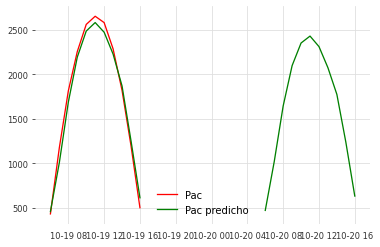

In [385]:
plt.plot(df_dia19['Pac'], 'r')
plt.legend()
plt.plot(df_dia19['Pac_predicho'], 'g')
plt.legend(['Pac','Pac predicho'])

plt.plot(df_dia20['Pac_predicho'],'g')

plt.show()

No handles with labels found to put in legend.


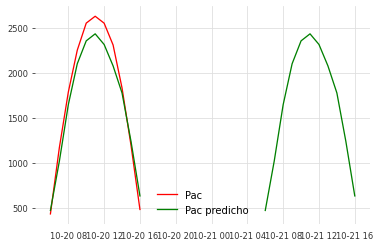

In [383]:
plt.plot(df_dia20['Pac'], 'r')
# plt.xticks(df_dia20['Pac'],df_dia20.index)
plt.legend()
plt.plot(df_dia20['Pac_predicho'], 'g')
plt.legend(['Pac','Pac predicho'])

plt.plot(df_dia21['Pac_predicho'],'g')
# plt.xticks(df_dia20.index)
plt.show()

In [371]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [386]:
rmse(df_dia19['Pac'], df_dia19['Pac_predicho'])

91.73642035953775

In [387]:
rmse(df_dia20['Pac'], df_dia20['Pac_predicho'])

159.56301405282846

In [388]:
rmse(df_dia21['Pac'], df_dia21['Pac_predicho'])

147.52706020982603

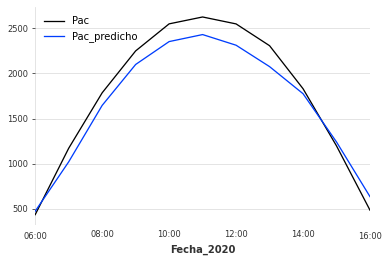

In [334]:
df_dia20[['Pac', 'Pac_predicho']].plot()

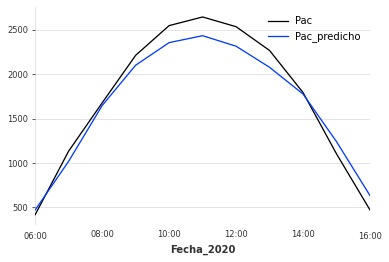

In [336]:
df_dia21[['Pac', 'Pac_predicho']].plot()

In [323]:
pd.Series(y_hat19.ravel())

0      459.482391
1     1011.763611
2     1687.880005
3     2194.258789
4     2487.160400
5     2582.782227
6     2474.284912
7     2229.086426
8     1870.877075
9     1256.284302
10     614.356384
dtype: float32